In [165]:
import random
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt

In [166]:
class RandomSelector:
    def __init__(self):
        self.proba = []
        self.somme = 0

    def add(self, i):
        self.proba.append(float(i))
        self.somme += i

    def random_choice(self):
        rand = random.random() * self.somme
        cumul = 0
        for j in range(len(self.proba)):
            cumul += self.proba[j]
            if rand < cumul:
                return j
        print("Error")
        return len(self.proba) - 1

In [167]:
class GeneticAlgorithm:
    def __init__(self, population_size: int, generations: int, mutation_rate: float, elitist_rate: float, items: List[Tuple[int, List[int]]], budgets: List[int]):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.elitist_rate = elitist_rate
        self.items = items
        self.budgets = budgets
        self.population = self.create_population(population_size, len(items))
 
    def create_population(self, size: int, n_items: int) -> List[List[int]]:
        population = []
        for _ in range(size):
            while True:
                solution = self.create_solution(n_items)
                total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
                if all(total_costs[j] <= self.budgets[j] for j in range(len(self.budgets))):
                    break
            population.append(solution)
        return population
    
    def create_solution(self, n_items: int) -> List[int]:
        return [random.randint(0, 1) for _ in range(n_items)]
 
    def fitness(self, solution: List[int]) -> int:
        return sum(solution[i] * self.items[i][0] for i in range(len(solution)))
 
    def selection(self) -> List[Tuple[List[int], List[int]]]:
        couples = []
        selector = RandomSelector()
        fitnesses = [self.fitness(solution) for solution in self.population]

        for i in range(len(fitnesses)):
            selector.add(fitnesses[i])
            
        for _ in range(self.population_size // 2):
            mother = self.population[selector.random_choice()]
            father = self.population[selector.random_choice()]
            #cpt = 1
            while mother == father:
                #cpt += 1
                father = self.population[selector.random_choice()]
            couples.append((mother, father))
        return couples
    
    def rank_selection(self) -> List[Tuple[List[int], List[int]]]:
        couples = []
        ranked_population = sorted(self.population, key=self.fitness)
        rank_costs = [i + 1 for i in range(len(ranked_population))]
        total_costs = sum(rank_costs)
        probabilities = [weight / total_costs for weight in rank_costs]

        selector = RandomSelector()
        for probability in probabilities:
            selector.add(probability)

        for _ in range(self.population_size // 2):
            mother = ranked_population[selector.random_choice()]
            father = ranked_population[selector.random_choice()]
            while mother == father:
                father = ranked_population[selector.random_choice()]
            couples.append((mother, father))
        return couples
 
    def uniform_crossover(self, parents: List[Tuple[List[int], List[int]]]) -> List[List[int]]:
        children =[]
        for parent in parents:
            child1 = []
            child2 = []
            for i in range(len(parent[0])):
                if random.uniform(0,1) < 0.5:
                    child1.append(parent[0][i])
                    child2.append(parent[1][i])
                else:
                    child1.append(parent[1][i])
                    child2.append(parent[0][i])
            children.append(child1)
            children.append(child2)
        return children
    
    def shuffle_crossover(self, parents: List[Tuple[List[int], List[int]]]) -> List[List[int]]:
        children = []
        for parent in parents:
            index = random.randint(0, len(parent[0]) - 1)
            child1 = parent[0][:index] + parent[1][index:]
            child2 = parent[1][:index] + parent[0][index:]
            children.append(child1)
            children.append(child2)
        return children
    
    def two_point_crossover(self, parents: List[Tuple[List[int], List[int]]]) -> List[List[int]]:
        children = []
        for parent in parents:
            start = random.randint(0, len(parent[0]) - 2)
            end = random.randint(start + 1, len(parent[0]) - 1)
            child1 = parent[0][:start] + parent[1][start:end] + parent[0][end:]
            child2 = parent[1][:start] + parent[0][start:end] + parent[1][end:]
            children.append(child1)
            children.append(child2)
        return children
    
    def bit_flip_mutation(self, solution: List[int]) -> List[int]:
        index = random.randint(0, len(solution) - 1)
        if random.random() < self.mutation_rate:
            solution[index] = 1 - solution[index]
        return solution
    
    def scramble_mutation(self, solution: List[int]) -> List[int]:
        if random.random() < self.mutation_rate:
            start = random.randint(0, len(solution) - 2)
            end = random.randint(start + 1, len(solution) - 1)
            subset = solution[start:end]
            random.shuffle(subset)
            solution[start:end] = subset
        return solution
 
    def repair(self, solution: List[int]) -> List[int]:
        total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
        is_valid = True
        for i in range(len(total_costs)):
            if total_costs[i] > self.budgets[i]:
                is_valid = False
                break
        if not is_valid:
            ordered_items = sorted(range(len(solution)), key=lambda x: self.items[x][0], reverse=True)
            for i in ordered_items: #remove item
                if solution[i] == 1:
                    for j in range(len(self.budgets)): 
                        if total_costs[j] > self.budgets[j]:
                            solution[i] = 0
                            total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
                            break
            for i in reversed(ordered_items): #add item
                if solution[i] == 0:
                    if all(total_costs[j] + self.items[i][1][j] <= self.budgets[j] for j in range(len(self.budgets))):
                        solution[i] = 1
                        total_costs = [sum(solution[i] * self.items[i][1][j] for i in range(len(solution))) for j in range(len(self.budgets))]
        return solution
 
    def run(self) -> Tuple[List[int], int, List[int]]:
        """generations_without_improvement = 0
        max_generations_without_improvement = 50
        best_fitness = 0"""
        best_solution = []
        for generation in range(self.generations):
            new_population = []

            # selection operation
            couples = self.selection()
            # couples = self.rank_selection()
    
            # crossover operation
            #children = self.uniform_crossover(couples)
            children = self.shuffle_crossover(couples)
            # children = self.two_point_crossover(couples)

            for child in children:
                # mutation operation
                child = self.bit_flip_mutation(child)
                # child = self.scramble_mutation(child)

                # repair operation
                child = self.repair(child)
                new_population.append(child)


            # elitism operation
            nb_elitist = int(self.population_size * self.elitist_rate)
            worst = sorted(new_population, key=self.fitness)
            best = sorted(self.population, key=self.fitness, reverse=True)
            for i in range(nb_elitist):
               #worst = min(new_population, key=self.fitness)
                #best = max(self.population, key=self.fitness)
                new_population.remove(worst[i])
                new_population.append(best[i])

            """if random.random() < self.elitist_rate:
                worst = min(new_population, key=self.fitness)
                best = max(self.population, key=self.fitness)
                new_population.remove(worst)
                new_population.append(best)"""
            
            self.population = new_population

            """current_best_solution = max(self.population, key=self.fitness)
            current_best_value = self.fitness(current_best_solution)

            if current_best_value > best_fitness:
                best_fitness = current_best_value
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1"""

            """if generations_without_improvement >= max_generations_without_improvement:
                print(f"Stopping early at generation {generation} due to no improvement")
                break"""
 
        best_solution = max(self.population, key=self.fitness)
        best_value = self.fitness(best_solution)
        best_costs = [sum(best_solution[i] * self.items[i][1][j] for i in range(len(best_solution))) for j in range(len(self.budgets))]
 
        return best_solution, best_value, best_costs

In [168]:
def multiple_runs(population_size: int, num_runs: int, generations: int, mutation_rate: float, elitist_rate: float, items: List[Tuple[int, List[int]]], budgets: List[int]):
    best_fitnesses = []
    for _ in range(num_runs):
        ga = GeneticAlgorithm(population_size, generations, mutation_rate, elitist_rate, items, budgets)
        best_solution, best_fitness, best_costs = ga.run()
        best_fitnesses.append(best_fitness)
    return best_fitnesses

[(100, [8, 8, 3, 5, 5, 5, 0, 3, 3, 3]), (600, [12, 12, 6, 10, 13, 13, 0, 0, 2, 2]), (1200, [13, 13, 4, 8, 8, 8, 0, 4, 4, 4]), (2400, [64, 75, 18, 32, 42, 48, 0, 0, 0, 8]), (500, [22, 22, 6, 6, 6, 6, 8, 8, 8, 8]), (2000, [41, 41, 4, 12, 20, 20, 0, 0, 4, 4])]


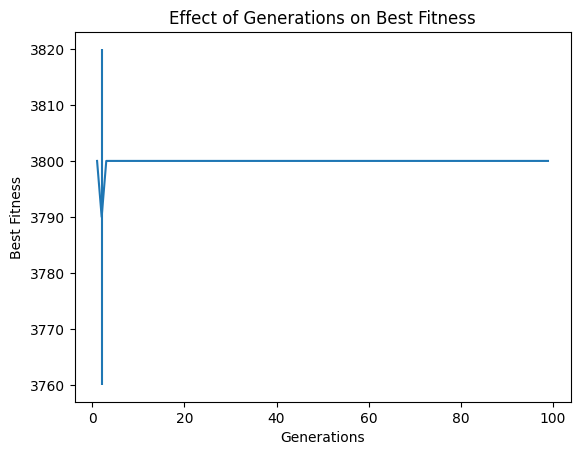

In [169]:
"""items = [
    (10, [5, 3]),
    (6, [4, 2]),
    (8, [6, 1]),
    (7, [3, 5])
]
budgets = [15, 10]"""
values = [100, 600, 1200, 2400, 500, 2000]
costs = [
    [8, 12, 13, 64, 22, 41],
    [8, 12, 13, 75, 22, 41],
    [3, 6, 4, 18, 6, 4],
    [5, 10, 8, 32, 6, 12],
    [5, 13, 8, 42, 6, 20],
    [5, 13, 8, 48, 6, 20],
    [0, 0, 0, 0, 8, 0],
    [3, 0, 4, 0, 8, 0],
    [3, 2, 4, 0, 8, 4],
    [3, 2, 4, 8, 8, 4]
]
 
# Combine values and costs into items
items = [(values[i], [cost[i] for cost in costs]) for i in range(len(values))]
print(items)
# Define the budgets
budgets = [80, 96, 20, 36, 44, 48, 10, 18, 22, 24]
population_size = 50
mutation_rate = 0.1
elitist_rate = 0.1
num_runs = 10
generation_rounds = [i for i in range(1,100)]

means = []
std_devs = []

for generations in generation_rounds:
    best_fitnesses = multiple_runs(population_size, num_runs, generations, mutation_rate, elitist_rate, items, budgets)
    mean = np.mean(best_fitnesses)
    std_dev = np.std(best_fitnesses)
    means.append(mean)
    std_devs.append(std_dev)
    #print(f"Generations: {generations}, Mean: {mean}, Std Dev: {std_dev}")

plt.errorbar(generation_rounds, means, yerr=std_devs)
#plt.plot(generation_rounds, means)
#plt.fill_between(generation_rounds, np.array(means) - np.array(std_devs), np.array(means) + np.array(std_devs), alpha=0.3)
plt.xlabel("Generations")
plt.ylabel("Best Fitness")
plt.title("Effect of Generations on Best Fitness")
plt.show()